In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
import math
from tqdm import tqdm

In [2]:
### MLP
class MultiLayerPerceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):

        self.depth = depth
        if depth ==-1:
            super(MultiLayerPerceptron, self).__init__()
            self.layer = nn.Linear(input_dim, output_dim, bias=isBiased)
        else:
            dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
            for i in range(depth):
                dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
            dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})
            super().__init__(dict)

        self.reset_init_weights_biases() # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = None):
        for layer in self.children():
            if norm == None:
                stdv = 1. / math.sqrt(layer.weight.size(1))
            else :
                stdv = norm
            
            layer.weight.data.uniform_(-stdv, stdv)
            if layer.bias is not None:
                layer.bias.data.uniform_(-stdv, stdv)


In [3]:
def train(model, input_data, output_data, untilConv = -1, lossFct = nn.MSELoss(), optimizer = 'SGD', lr=0.001, epochs = 20, batch_size=None, return_vals = True, init_norm = None, save = True, debug = False, savename='model.pt'):

    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer == 'ASGD':
        optimizer = torch.optim.ASGD(model.parameters(), lr=lr)
    elif optimizer == 'GD':
        optimizer = GD(model.parameters(), lr=lr)
    
    if init_norm is not None:
        model.reset_init_weights_biases(init_norm)
    
    if return_vals:
        errors = np.zeros(epochs)

    n = len(input_data)
    if batch_size is not None:
        n_batches = n//batch_size

    post_grad = 0
    for i in range(epochs):
        rand_idx = torch.randperm(n) # permutation of data samples
        if batch_size is not None:
            loss = 0
            for t in range(n_batches):
                idx = rand_idx[t*batch_size:(t+1)*batch_size]
                y_pred = model(input_data[idx,:]).squeeze_()
                loss += lossFct(y_pred, output_data[idx])
        else:
            y_pred = model(input_data[rand_idx,:]).squeeze_()
            loss = lossFct(y_pred, output_data[rand_idx])
            
        if return_vals:
            errors[i] = loss.item()

            #if math.isnan(loss.item()):
                #print(f"Epoch: {i+1}   Loss: {loss.item()}")
                #break

        optimizer.zero_grad()
        loss.backward()
        
        grad = 0
        for layer in model.children():
            grad += layer.weight.grad.mean()
        grad = abs(grad)
        
        if abs(post_grad - grad) <=untilConv:
            print("Convergence")
            break
        post_grad = grad
        
        optimizer.step()

        if debug:
            if (i+1)%(epochs/debug) == 0:
                print(f"Epoch: {i+1}   Loss: {loss.item():.3e}")

    if save:
        torch.save(model.state_dict(), DIRPATH+savename)
    
    if return_vals:
        return errors

In [4]:
def Generate_data(p = 100, n = 500, sigma2 = 2):
        ### Data generation
    data = np.random.multivariate_normal(
        np.zeros(p),
        np.ones((p,p)),
        size=n) # shape (n,p)

    w_true = np.ones(p)*1/np.sqrt(p)

    observations = [np.random.normal(
        np.dot(w_true, x),
        sigma2)
        for x in data]
    observations = np.array(observations) # shape (n,)

    return data, observations
    

In [5]:
def Ridge_Lambda_Compute(A,b,LambdaArray):
    error = np.zeros((LambdaArray.shape[0]))
    for i in range(LambdaArray.shape[0]):
        res = ridge(A,b,LambdaArray[i])
        error[i] = objective(A,b,res)
    ridgeErrorArray = np.hstack((LambdaArray[:,np.newaxis],error[:,np.newaxis]))
    return ridgeErrorArray

In [6]:
def extract_weight(MLP):
    sol_MLP = torch.eye(d)
    for layer in MLP.children():
        sol_MLP = sol_MLP@torch.transpose(layer.weight,0,1)
    return sol_MLP.numpy()

100%|██████████| 200/200 [41:44<00:00, 12.52s/it]


[[0.         3.96858747]
 [1.         3.96858746]
 [2.         3.96858746]
 [3.         3.96858743]
 [4.         5.20651134]
 [5.         9.59163938]]
[[103.9643642   67.92019119  44.91131624 ...   3.96858746   3.96858744
    3.96858747]
 [103.62368843  89.24061623  76.20745815 ...   3.96858746   3.96858744
    3.96858746]
 [103.72458744  98.47498123  93.19445339 ...   3.96858746   3.96858747
    3.96858746]
 [103.62325581 103.40993385 103.19111259 ...   3.96858744   3.96858743
    3.96858743]
 [103.68048412 103.67677784 103.67306187 ...   5.2069055    5.13471177
    5.20651134]
 [103.67857792 103.67807457 103.6775679  ...   9.96933875   9.89750937
    9.59163938]]


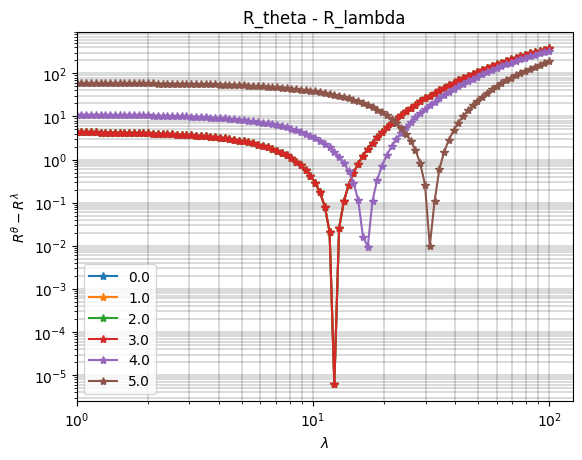

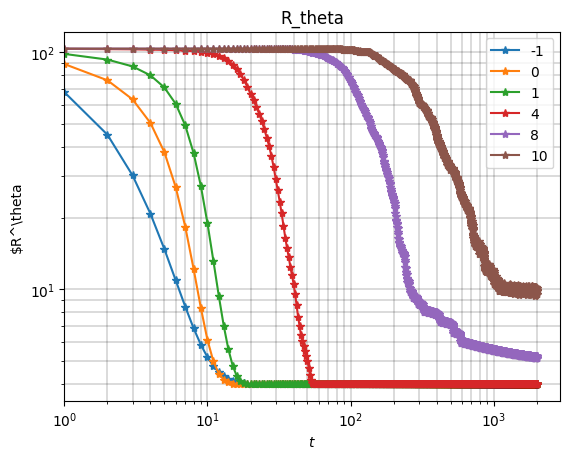

In [7]:
%run utils.py
%run Plot_lib.ipynb

nb_avg=200
p=100
intern_dim= 10
epochs = 2000
untilConv = -1

depthArray = np.array([-1,0,1,4,8,10])
errorArray = np.zeros((nb_avg,depthArray.shape[0],2))
modelErrorArray = np.zeros((nb_avg,depthArray.shape[0],epochs))

for f in tqdm(range(nb_avg)):
    
    A,b = Generate_data(p=p, n=500)
    
    for i in range(depthArray.shape[0]):
        model = MultiLayerPerceptron(input_dim=p,
                                     intern_dim=intern_dim,
                                     output_dim=1,
                                     depth=depthArray[i],
                                     isBiased = False)
        error,e = train(model, torch.from_numpy(A).to(torch.float32), torch.from_numpy(b).to(torch.float32), untilConv = untilConv, save = False, epochs = epochs)
        modelErrorArray[f,i] = error
        errorArray[f,i] = [i,error[e]]
    
LambdaArray = np.logspace(0,2,100)
ridgeErrorArray = Ridge_Lambda_Compute(A,b,LambdaArray)

mean_errorArray = np.mean(errorArray, axis=0)
print(mean_errorArray)
mean_modelErrorArray = np.mean(modelErrorArray, axis=0)
print(mean_modelErrorArray)

plot_MvsR_overLambda(mean_errorArray, ridgeErrorArray)
plot_M_overStep(mean_modelErrorArray,depthArray)